# Data Set Information:
The actual concrete compressive strength (MPa) for a given mixture under a  specific age (days) was determined from laboratory. Data is in raw form (not scaled). The data has 8 quantitative input variables, and 1 quantitative output variable, and 1030 instances (observations). 
Concrete is the most important material in civil engineering. The concrete compressive strength is a highly nonlinear function of age and ingredients. These ingredients include cement, blast furnace slag, fly ash, water, superplasticizer, coarse aggregate, and fine aggregate. 



# Objective:  
Modeling of strength of high performance concrete using Machine Learning 

In [1]:
# Import necessary Libraries
import pandas as pd
import numpy as np
import seaborn as sns
from numpy import percentile
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

# For scaling
from scipy.stats import zscore
from sklearn import preprocessing

# for Box-Cox Transformation
from scipy import stats

#For Models
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFE
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor

#For Evaluation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix ,classification_report,accuracy_score
from sklearn.metrics import precision_score ,recall_score,f1_score
from sklearn.decomposition import PCA
from sklearn.utils import resample
from sklearn.metrics import accuracy_score
from sklearn import metrics
from scipy.stats import randint as sp_randint

sns.set_style(style='darkgrid')

# Data pre-processing

In [18]:
c_df= pd.read_csv("concrete.csv")
c_df.head(10)

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29
5,255.0,0.0,0.0,192.0,0.0,889.8,945.0,90,21.86
6,166.8,250.2,0.0,203.5,0.0,975.6,692.6,7,15.75
7,251.4,0.0,118.3,188.5,6.4,1028.4,757.7,56,36.64
8,296.0,0.0,0.0,192.0,0.0,1085.0,765.0,28,21.65
9,155.0,184.0,143.0,194.0,9.0,880.0,699.0,28,28.99


### 1.a.i. Univariate analysis 

In [19]:
c_df.shape

(1030, 9)

In [21]:
#Checking Missing Values
c_df.isna().values.any()

False

In [22]:
c_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
cement          1030 non-null float64
slag            1030 non-null float64
ash             1030 non-null float64
water           1030 non-null float64
superplastic    1030 non-null float64
coarseagg       1030 non-null float64
fineagg         1030 non-null float64
age             1030 non-null int64
strength        1030 non-null float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


- The dataset is of shape (1030,9)
- Out of 8 independent variable, none of them have null values
- All the columns are read as numeric columns (either float or int)
- All the independent variables are Continuous columns
- Target columns : 'strength' which is also Continuous variable

In [23]:
c_df.describe().T

,count,mean,std,min,25%,50%,75%,max
cement,1030.0,281.167864,104.506364,102.00,192.375,272.900,350.000,540.0
slag,1030.0,73.895825,86.279342,0.00,0.000,22.000,142.950,359.4
ash,1030.0,54.188350,63.997004,0.00,0.000,0.000,118.300,200.1
water,1030.0,181.567282,21.354219,121.80,164.900,185.000,192.000,247.0
superplastic,1030.0,6.204660,5.973841,0.00,0.000,6.400,10.200,32.2
coarseagg,1030.0,972.918932,77.753954,801.00,932.000,968.000,1029.400,1145.0
fineagg,1030.0,773.580485,80.175980,594.00,730.950,779.500,824.000,992.6
age,1030.0,45.662136,63.169912,1.00,7.000,28.000,56.000,365.0
strength,1030.0,35.817961,16.705742,2.33,23.710,34.445,46.135,82.6


- Independent variables - slag, ash, superplastic have 25% or more of records as 0, thus they may seem as rightly skewed
- Age is skewed towards the right as 75% of the data is within 56 and suddenly the max value rises to 365
- Other columns seem normally distributed and increase gradually

In [24]:
c_df.skew()

cement          0.509481
slag            0.800717
ash             0.537354
water           0.074628
superplastic    0.907203
coarseagg      -0.040220
fineagg        -0.253010
age             3.269177
strength        0.416977
dtype: float64

In [32]:
#we will replace all the outliers with the median
for record in c_df.columns[:-1]:
    q1 = c_df[record].quantile(0.25)
    q3 = c_df[record].quantile(0.75)
    iqr = q3 - q1
    low = q1- iqr*1.5
    high = q3 + iqr*1.5
    c_df.loc[(c_df[record]<low)|(c_df[record]>high),record]=c_df[record].median()

In [33]:
#Now lets re-check the skewness of each column
c_df.skew()

cement          0.509481
slag            0.775981
ash             0.537354
water           0.089598
superplastic    0.468146
coarseagg      -0.040220
fineagg        -0.332890
age             1.286884
strength        0.416977
dtype: float64

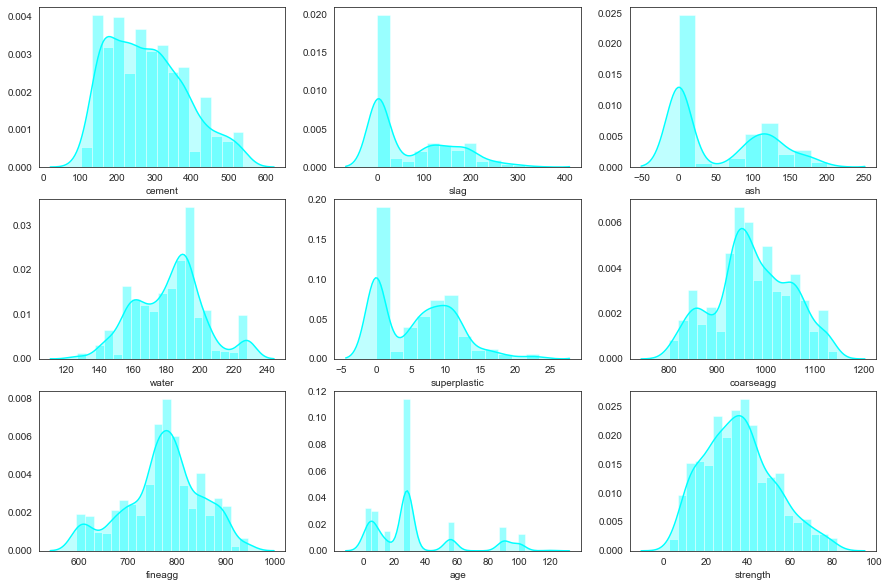

In [36]:
#Now we will plot the Dist plot and check each distrubution independantly
plt.figure(figsize=(15,10))
pos = 1
for i in c_df:
    plt.subplot(3, 3, pos)
    sns.distplot(c_df[i],color='cyan', kde_kws={"shade": True})
    pos += 1 

- Cement : Almost normally ditributed but slightly skewed towards the right
- slag : More than 25% of the records are 0 and then they slowly increase, thus we find 2 gaussian distribution
- ash : Again, more than 50% of the records are 0 and then they slowly increase, thus we find 2 gaussian distribution
- water : The distribution of water can see 3 peaks which is 3 gaussian distributions.
- superplastic : More than 25% of the records are 0 and then they slowly increase, thus we find 2 peaks in the distribution and so 2 gaussian distribution
- coarseagg : Here as well we can find fluctuating distributions with 2 peaks thus 2 gaussian distribution can be found
- fineagg : Almost close to normally distributed graph
- age : The age variable has 4 prominant peaks at 0, 30, 60 and 90 distributing the data into 4 gaussian belts.
- strength : This column being the target variable is normally distributed.

### Multivariate analysis

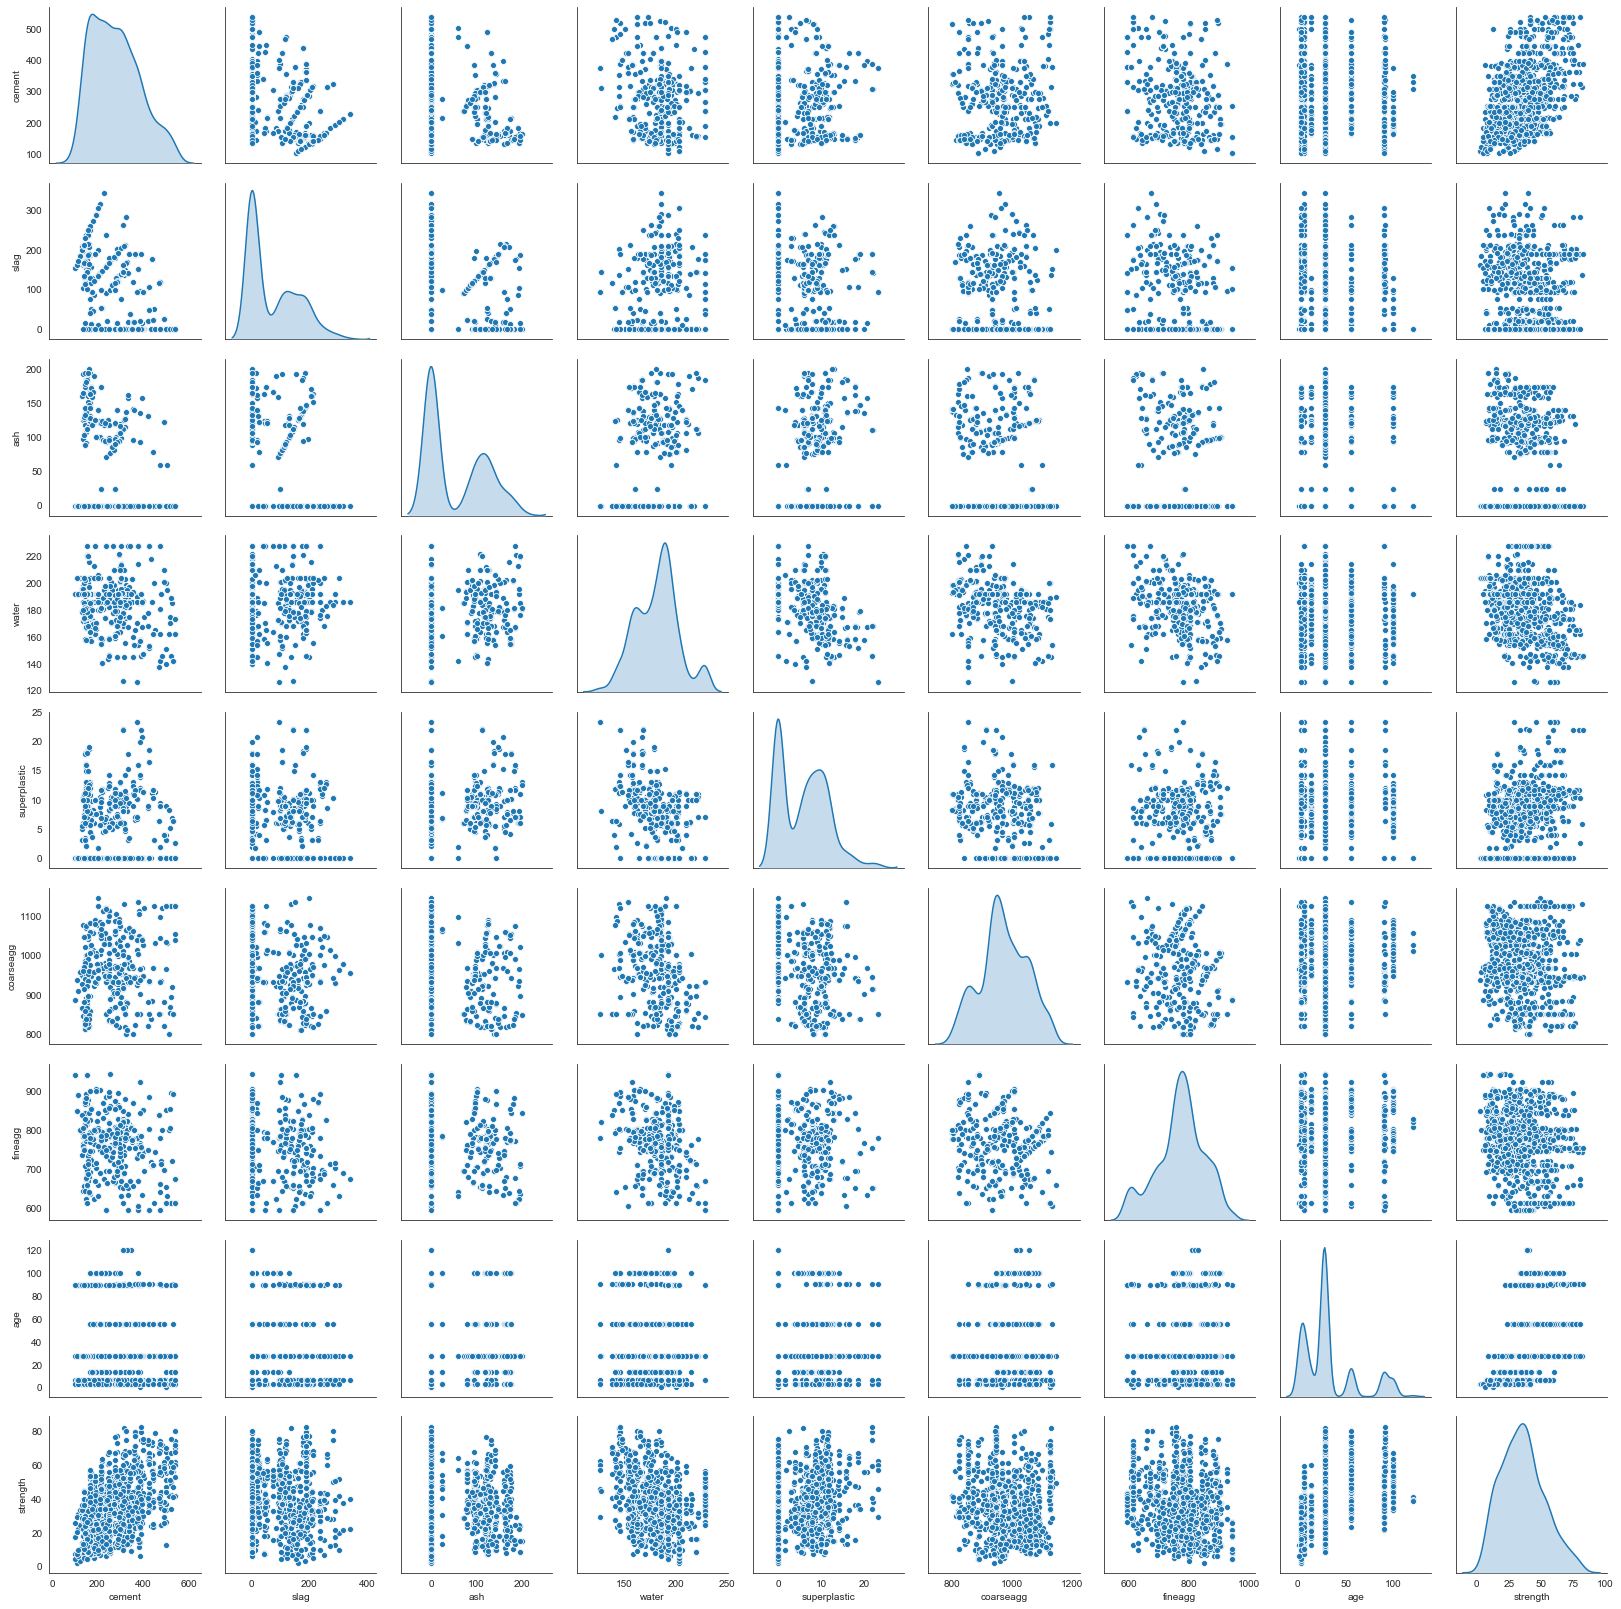

In [37]:
sns.pairplot(c_df, diag_kind = 'kde', palette='GnBu_d')
plt.show()

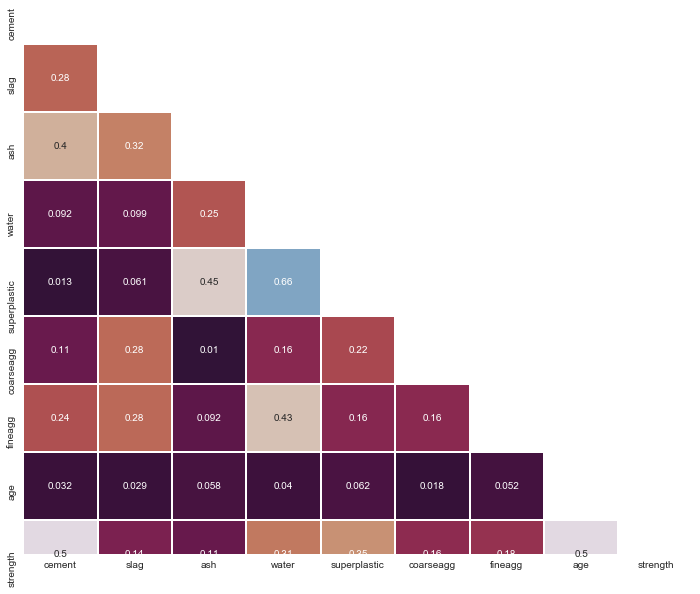

In [38]:
corr = abs(c_df.corr()) # correlation matrix
lower_triangle = np.tril(corr, k = -1)  # select only the lower triangle of the correlation matrix
mask = lower_triangle == 0  # to mask the upper triangle in the following heatmap

plt.figure(figsize = (12,10))  # setting the figure size
sns.set_style(style = 'white')  # Setting it to white so that we do not see the grid lines
sns.heatmap(lower_triangle, center=0.5, cmap= 'twilight_shifted_r', annot= True, xticklabels = corr.index, yticklabels = corr.columns,
            cbar= False, linewidths= 1, mask = mask)   
plt.show()

In [39]:
#Correlation Matrix
c_df.corr()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
cement,1.000000,-0.275046,-0.397467,-0.091614,0.013336,-0.109349,-0.238698,-0.031962,0.497832
slag,-0.275046,1.000000,-0.320468,0.098880,0.061195,-0.283882,-0.282383,-0.028971,0.137800
ash,-0.397467,-0.320468,1.000000,-0.248011,0.447492,-0.009961,0.091729,0.057928,-0.105755
water,-0.091614,0.098880,-0.248011,1.000000,-0.658056,-0.156928,-0.426299,-0.040304,-0.307711
superplastic,0.013336,0.061195,0.447492,-0.658056,1.000000,-0.224503,0.156591,0.062013,0.346260
coarseagg,-0.109349,-0.283882,-0.009961,-0.156928,-0.224503,1.000000,-0.161377,0.018078,-0.164935
fineagg,-0.238698,-0.282383,0.091729,-0.426299,0.156591,-0.161377,1.000000,0.051532,-0.182186
age,-0.031962,-0.028971,0.057928,-0.040304,0.062013,0.018078,0.051532,1.000000,0.499850
strength,0.497832,0.137800,-0.105755,-0.307711,0.346260,-0.164935,-0.182186,0.499850,1.000000


- **cement** is around 50% correlated with **strength** and have negative correlation with other variables at certain levels
- **strength** is around 50% correlated to **age** and **cement**, but as age and cement are very lightly negatively correlated with each other, thus both these factors are the main role players to determine the strength
- **fineagg** is 42% negatively correlated with **water**, which is in-turn 30% negatively correlated with **strength**
- **water** and **superplastic** are 65% negatively correlated, which is why **water** is 30% negatively correlated with **strength** and **superplastic** is 34% positively correlated to **strength** 

In [148]:
abs(corr["strength"]).sort_values(ascending=False)

strength        1.000000
age             0.499850
cement          0.497832
superplastic    0.346260
water           0.307711
fineagg         0.182186
coarseagg       0.164935
slag            0.137800
ash             0.105755
Name: strength, dtype: float64

## Scaling the data and splitting the data into independent and target variables

In [41]:
# Copy all the predictor variables into X dataframe. Since 'strength' is dependent variable drop it
x = c_df.drop('strength', axis=1)
X = x.apply(zscore)
# Copy the 'strength' column alone into the y dataframe. This is the dependent variable
y = c_df[['strength']]


## Train/Validate and Test Split

In [42]:
X_train_plus_validate, X_test, y_train_plus_validate, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

In [44]:
print(X_train_plus_validate.shape)
print(y_train_plus_validate.shape)

(721, 8)
(721, 1)


## Train split to Train and validate keeping Test aside for final evaluation: 

In [48]:
#Now  we will keep the test aside and split te train into 2 parts as train and validate.
#At last we will check the test dataset .This is done to avoid data leakage.
X_train, X_validate, y_train, y_validate = train_test_split(X_train_plus_validate, y_train_plus_validate, test_size=0.20, random_state=1)
print("Size of the training dataframe is ",len(X_train))
print("Size of the test dataframe is ",len(X_validate))
print("{0:0.2f}% data is in training set".format((len(X_train)/len(y_train_plus_validate.index)) * 100))
print("{0:0.2f}% data is in test set".format((len(X_validate)/len(y_train_plus_validate.index)) * 100))

Size of the training dataframe is  576
Size of the test dataframe is  145
79.89% data is in training set
20.11% data is in test set


In [49]:
X_train.shape

(576, 8)

## Linear Regression 

In [50]:
regression_model = LinearRegression()
regression_model.fit(X_train, y_train)

for idx, col_name in enumerate(X_train.columns):
    print("The coefficient for {} is {}".format(col_name, regression_model.coef_[0][idx]))

The coefficient for cement is 10.347156493454625
The coefficient for slag is 5.633853257259282
The coefficient for ash is 1.9965830511870035
The coefficient for water is -2.766197611250077
The coefficient for superplastic is 2.135794220060188
The coefficient for coarseagg is -0.6484611855270368
The coefficient for fineagg is -0.9549363569841258
The coefficient for age is 8.834186270051866


In [51]:
intercept = regression_model.intercept_[0]

print("The intercept for our model is {}".format(intercept))

The intercept for our model is 35.557961496659196


## Regularization:Ridge Model 

In [52]:
# Create a regularized RIDGE model and note the coefficients
ridge = Ridge(alpha=.3)
ridge.fit(X_train,y_train)
print ("Ridge model:", (ridge.coef_))    

Ridge model: [[10.30558261  5.59550282  1.9635252  -2.78951109  2.13652522 -0.67286533
  -0.9857043   8.82991026]]


## Regularization:Lasso Model  

In [53]:
# Create a regularized LASSO model and note the coefficients
lasso = Lasso(alpha=0.1)
lasso.fit(X_train,y_train)
print ("Lasso model:", (lasso.coef_))

# None of the coefficients have become 0 indicating there is significance of each column

Lasso model: [ 9.98219618  5.28601898  1.58167445 -2.63570653  2.33191557 -0.6384476
 -0.96860971  8.72230036]


## Let us compare their scores

In [54]:
regTrain=regression_model.score(X_train, y_train)
regValidate=regression_model.score(X_validate, y_validate)

In [55]:
ridgeTrain=ridge.score(X_train, y_train)
ridgeValidate=ridge.score(X_validate, y_validate)

In [56]:
lassoTrain=lasso.score(X_train, y_train)
lassoValidate=lasso.score(X_validate, y_validate)

In [58]:
Scores1 = pd.DataFrame({'Model' : ['LinearRegression', 'Ridge', 'Lasso'],
                        'TrainingSetScore:':[regTrain,ridgeTrain,lassoTrain],     
                      'ValidateSetScore': [ regression_model.score(X_validate, y_validate) ,  ridge.score(X_validate, y_validate) , lasso.score(X_validate, y_validate)]})
Scores1

,Model,TrainingSetScore:,ValidateSetScore
0,LinearRegression,0.728304,0.677726
1,Ridge,0.728303,0.677694
2,Lasso,0.727876,0.676316


- All the models are giving almost same accuracy score in case of linear model

# Let us generate polynomial models reflecting the non-linear interaction between dimensions

In [59]:
poly = PolynomialFeatures(degree = 2, interaction_only=True)

#poly = PolynomialFeatures(2)

In [144]:
X_poly = poly.fit_transform(X_train_plus_validate)
#Now  we will keep the test aside and split te train into 2 parts as train and validate.
#At last we will check the test dataset .This is done to avoid data leakage.
X_train_poly, X_validate_poly, y_train_poly, y_validate_poly = train_test_split(X_poly, y_train_plus_validate, test_size=0.20, random_state=1)


In [145]:
X_validate_poly.shape

(145, 37)

In [146]:
regression_model.fit(X_train_poly, y_train_poly)
print(regression_model.coef_[0])

[ 5.09816792e-16  1.06619769e+01  7.10044728e+00  2.68705847e+00
 -3.00792309e+00  1.88926075e+00 -5.14690375e-01 -6.99768366e-01
  8.69730247e+00  1.64117152e+00  1.65482376e+00 -3.94628666e+00
 -2.73004894e+00  1.29487991e+00  1.24549050e-01  2.06761934e+00
  1.56440387e+00 -2.21145854e+00 -5.39651290e-01  1.54397328e+00
  1.51738608e+00  2.78014323e+00 -5.03554837e+00 -4.58262384e+00
  5.44510625e-01 -7.04657556e-02  2.17120367e+00  1.14912112e+00
 -2.70007007e+00 -4.52243034e-01  6.48188843e-02 -1.06435506e+00
  7.31815343e-01  2.01241829e-01  1.75226004e+00  6.27171519e-01
  8.67836996e-01]


In [147]:
regTrain = regression_model.score(X_train_poly, y_train_poly)
regVal = regression_model.score(X_validate_poly, y_validate_poly)
print(regTrain)
print(regVal)

0.794481105722444
0.7109021175680291


In [148]:
ridge = Ridge(alpha=.3)
ridge.fit(X_train_poly,y_train_poly)
print ("Ridge model:", (ridge.coef_))

Ridge model: [[ 0.         10.58356007  7.01530733  2.62413793 -3.06051051  1.88598261
  -0.56189626 -0.76215063  8.70057761  1.61844653  1.63766976 -3.88739137
  -2.6455492   1.29194902  0.12607429  2.02232137  1.53976256 -2.17119678
  -0.47118809  1.53256175  1.51502336  2.73737662 -4.96649017 -4.50972318
   0.54208113 -0.05758845  2.13317086  1.17435538 -2.67348757 -0.44234329
   0.03283896 -1.01924849  0.77561419  0.19717383  1.74999483  0.60034644
   0.82750285]]


In [149]:
ridgeTrain = ridge.score(X_train_poly, y_train_poly)
ridgeVal = ridge.score(X_validate_poly, y_validate_poly)
print(ridgeTrain)
print(ridgeVal)


0.794475188995275
0.7107688910294296


In [150]:
lasso = Lasso(alpha=0.01)
lasso.fit(X_train_poly,y_train_poly)
print ("Lasso model:", (lasso.coef_))

Lasso model: [ 0.         10.5185143   6.91974554  2.53878963 -3.06458035  1.89199091
 -0.5722838  -0.75800133  8.74189631  1.49674313  1.47290101 -3.6290774
 -2.25813821  1.22558965  0.12814728  1.71243786  1.37408351 -1.91550016
 -0.0978951   1.47786053  1.54983733  2.43785799 -4.65624669 -4.12024108
  0.44313337 -0.          1.89148436  1.23867743 -2.52306293 -0.36193734
 -0.17768578 -0.73371756  0.97459909  0.17005744  1.76251581  0.38531492
  0.54006816]


In [151]:
lassoTrain = lasso.score(X_train_poly, y_train_poly)
lassoVal = lasso.score(X_validate_poly, y_validate_poly)
print(lassoTrain)
print(lassoVal)

0.7942989153774428
0.7123889472961338


In [152]:
Scores2 = pd.DataFrame({'Model' : ['LinearRegression_poly2', 'Ridge_poly2', 'Lasso_poly2'],
                        'TrainingSetScore:':[regTrain,ridgeTrain,lassoTrain],     
                      'ValidateSetScore': [ regVal, ridgeVal , lassoVal]})
Scores2

,Model,TrainingSetScore:,ValidateSetScore
0,LinearRegression_poly2,0.794481,0.710902
1,Ridge_poly2,0.794475,0.710769
2,Lasso_poly2,0.794299,0.712389


- On changing the model to quadratic, we see a rise in accuracy of both, the train and validate dataset.
- But still, all the models have achieved almost the same accuracy

### Polynomial to the degree 3 

In [68]:
poly = PolynomialFeatures(degree = 3, interaction_only=True)

#poly = PolynomialFeatures(3)

In [69]:
X_poly3 = poly.fit_transform(X_train_plus_validate)
#Now  we will keep the test aside and split te train into 2 parts as train and validate.
#At last we will check the test dataset .This is done to avoid data leakage.
X_train_poly3, X_validate_poly3, y_train_poly3, y_validate_poly3 = train_test_split(X_poly3, y_train_plus_validate, test_size=0.20, random_state=1)


In [70]:
X_validate_poly3.shape

(145, 93)

In [71]:
regression_model.fit(X_train_poly3, y_train_poly3)
print(regression_model.coef_[0])

[-2.72413223e-16  1.29944393e+01  7.76582144e+00  4.07903571e+00
 -2.42720302e+00  6.97275589e-01  1.71690525e+00  1.99685131e+00
  7.94771672e+00  1.39010331e-01  1.92982101e+00 -2.63705932e-01
  1.13645667e+00  1.16947723e+00  1.85343136e+00  1.69702087e+00
  2.51406939e+00 -2.63930161e+00 -8.42144624e-01 -4.70388830e-01
  1.61955073e+00  2.32083373e+00 -3.13768831e+00 -5.19661880e+00
 -6.58574821e-01  4.85166509e-02  2.30650772e+00  1.78823368e+00
 -4.35158936e+00 -3.90287678e-01 -2.01496821e+00  4.76074205e-01
  2.50914026e+00 -2.20482660e-01  6.80255715e-01  4.22565605e-01
  1.93720003e-01  1.70144908e-01  9.38934676e-01 -6.14208977e-01
 -3.09464355e-01  1.55163454e+00 -1.51490115e+00  1.30665091e+00
 -2.19917809e+00 -7.28341230e-01  1.01780829e+00  3.46755335e-01
  3.33509110e+00  3.16107538e+00  1.25430915e+00  3.87415743e+00
  7.96161246e-01  3.17193211e-01  3.89737926e+00 -2.13523006e-01
 -9.86800855e-02  7.39716786e-01  8.38029644e-01 -2.48760683e+00
  1.70970965e+00  2.82098

In [72]:
print(regression_model.score(X_train_poly3, y_train_poly3))
print(regression_model.score(X_validate_poly3, y_validate_poly3))

0.8489489088496089
0.6525377711637259


In [73]:
ridge = Ridge(alpha=.3)
ridge.fit(X_train_poly3,y_train_poly3)
print ("Ridge model:", (ridge.coef_))

Ridge model: [[ 0.00000000e+00  1.25830064e+01  7.39120585e+00  3.71613907e+00
  -2.50568875e+00  8.80091851e-01  1.49642301e+00  1.71584644e+00
   7.96627761e+00 -2.62939579e-03  1.73503664e+00 -2.93292195e-01
   1.20068657e+00  1.08676626e+00  1.77403162e+00  1.57598899e+00
   2.24771937e+00 -2.62960980e+00 -7.00107277e-01 -5.21363443e-01
   1.54898935e+00  2.20615142e+00 -3.07638825e+00 -5.00658761e+00
  -7.11478267e-01 -2.97111308e-02  2.18129849e+00  1.79218058e+00
  -4.32981592e+00 -3.94567238e-01 -2.01888636e+00  5.35476227e-01
   2.54290035e+00 -1.37332459e-01  6.72060147e-01  3.65569132e-01
   1.11819448e-01  4.53480217e-04  9.03457106e-01 -5.57298050e-01
  -4.07840007e-01  1.46978165e+00 -1.53992057e+00  1.32000419e+00
  -2.01915376e+00 -7.90189371e-01  9.22447388e-01  3.12645474e-01
   3.26958879e+00  3.10487937e+00  1.28130882e+00  3.76536039e+00
   8.06602115e-01  3.79290691e-01  3.77999349e+00 -2.18151690e-01
  -1.10066883e-01  7.10913941e-01  8.24830938e-01 -2.33046986e+

In [74]:
print(ridge.score(X_train_poly3, y_train_poly3))
print(ridge.score(X_validate_poly3, y_validate_poly3))


0.8489139895800926
0.6549803272137857


In [75]:
lasso = Lasso(alpha=0.01)
lasso.fit(X_train_poly3,y_train_poly3)
print ("Lasso model:", (lasso.coef_))

Lasso model: [ 0.         11.86949041  6.95969163  3.20519173 -2.55165525  1.14387274
  0.91206684  0.92007398  8.14530052 -0.          1.4327117  -0.23998439
  0.95275206  1.00679496  1.58471161  1.08362011  1.48351468 -1.99560769
 -0.         -0.17682919  1.62067627  1.71298866 -2.61643769 -4.35203455
 -0.54194227 -0.          1.62605699  1.55847277 -4.26156346 -0.53716825
 -1.98031529  0.31426577  2.12499369  0.28071215  0.57788902  0.10165973
 -0.23726755 -0.36842155  0.6785672  -0.4571514  -0.46394462  1.29636895
 -1.52786027  1.25961194 -1.57567383 -0.80171482  0.72537723  0.15110368
  2.85432757  2.9843026   1.37321515  3.10842385  0.63124465  0.37033455
  3.00277943 -0.14923163 -0.10133743  0.55628088  0.73545295 -1.70619823
  1.30176907  2.09259341 -1.58877212  0.91767521 -0.06949487  1.48438324
  0.         -1.61570222 -0.97455586  2.17925972  0.78966946  0.17196674
  0.21959208  0.69914325  2.20477997 -0.25791531  1.36087569 -2.09548318
 -0.99557648  3.75007802 -1.12314632 -

In [76]:
print(lasso.score(X_train_poly3, y_train_poly3))
print(lasso.score(X_validate_poly3, y_validate_poly3))

0.8479873653017579
0.6645191570216744


- Here as well we see, all the 3 models, Linear Regression, ridge and lasso, all have achieved the same accuracy level
- We notice a huge accuracy difference between the training and the validation dataset. Thus this can't be selected as an good model

## Decision trees model analysis 

In [77]:
d_tree_model = DecisionTreeRegressor()

In [78]:
parameters={'min_samples_split' : range(10,500,20),'max_depth': range(1,20,2)}
modelChk =GridSearchCV(estimator=d_tree_model,
             param_grid={'min_samples_split' : range(10,500,20),'max_depth': range(1,20,2)})

modelChk.fit(X_train, y_train)

print("Best Hyper Parameters:\n", modelChk.best_params_)

D:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best Hyper Parameters:
 {'max_depth': 13, 'min_samples_split': 10}


In [80]:
modelChk.best_estimator_

DecisionTreeRegressor(criterion='mse', max_depth=13, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=10, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [81]:
best_mod = DecisionTreeRegressor(criterion='mse', max_depth=13, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=10, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [83]:
best_mod.fit(X_train, y_train)
best_mod.score(X_train, y_train)

0.9569768375008243

In [84]:
best_mod.fit(X_validate, y_validate) 
best_mod.score(X_validate, y_validate)

0.900254444274567

In [312]:
print (pd.DataFrame(d_tree_model.feature_importances_, columns = ["Imp"], index = X_train.columns))

                   Imp
cement        0.355044
slag          0.112765
ash           0.007823
water         0.102175
superplastic  0.036962
coarseagg     0.020080
fineagg       0.030298
age           0.334852


- The best fit DecisionTreeRegressor gives good accuarcy score in both training and validate dataset with a difference of ~5%
- Hyperparameter tuning has enhanced the performance of the model and feature importance is also shown as above

## sending the poly data set of degree 2 to the decision tree model 

In [85]:
d_tree_model.fit(X_train_poly, y_train_poly)
d_tree_model.score(X_train_poly, y_train_poly)

0.991601461356818

In [137]:
X_train_poly.shape

(576, 37)

In [86]:
d_tree_model.fit(X_validate_poly, y_validate_poly)
d_tree_model.score(X_validate_poly, y_validate_poly)

0.9964693677528228

- The quadratic polynomial model works extremely good in both train and validate dataset with almost 99% accuracy.

### PCA 

In [100]:
pca = PCA(n_components=6)
pca.fit(X_train_plus_validate)

PCA(copy=True, iterated_power='auto', n_components=6, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [101]:
print(pca.components_)

[[ 2.33895215e-01  1.88310880e-01 -4.76944667e-01  5.14660251e-01
  -4.85545628e-01 -5.88327665e-03 -4.18253101e-01 -8.21938273e-02]
 [-3.07847819e-01  7.27682746e-01 -5.87312906e-02  3.55699582e-02
   2.35224059e-01 -5.61831054e-01  4.83099657e-04  2.86885268e-03]
 [ 7.41050799e-01 -3.49454864e-03 -3.76279853e-01 -3.73613131e-01
   3.17163173e-01 -2.62112504e-01  1.85400362e-02 -4.36193463e-03]
 [-4.69513644e-02 -1.31160627e-01 -2.66182154e-01  1.17851816e-01
  -2.71942404e-01 -2.18730572e-01  5.46521311e-01  6.89470225e-01]
 [ 2.41521794e-02  2.22995438e-01  6.78212311e-02 -1.15251517e-01
   2.27379524e-01  3.59531795e-01 -5.11692307e-01  6.99295001e-01]
 [ 2.16461708e-01 -3.52242472e-01  4.93314855e-01  4.16756013e-01
   1.36384147e-01 -5.42316034e-01 -2.69925927e-01  1.62656473e-01]]


In [102]:
print(pca.explained_variance_ratio_)

[0.26844908 0.17604066 0.16200383 0.12932716 0.11999602 0.11618461]


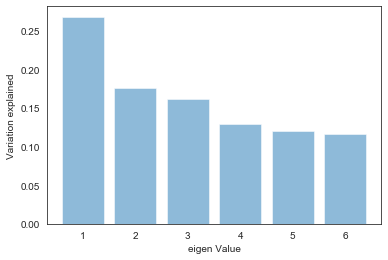

In [104]:
plt.bar(list(range(1,7)),pca.explained_variance_ratio_,alpha=0.5, align='center')
plt.ylabel('Variation explained')
plt.xlabel('eigen Value')
plt.show()

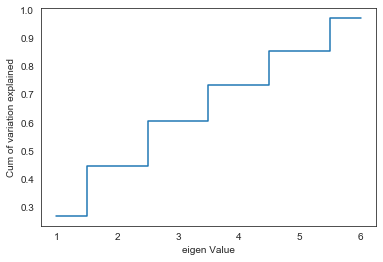

In [106]:
plt.step(list(range(1,7)),np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Cum of variation explained')
plt.xlabel('eigen Value')
plt.show()

- We find that variance of 90% is acheived with 6 independent variables out of 8

In [108]:
pca6 = PCA(n_components=6)
pca6.fit(X)
print(pca6.components_)
print(pca6.explained_variance_ratio_)
Xpca6 = pca6.transform(X_train_plus_validate)

[[ 0.13864521  0.20081759 -0.45490138  0.54199264 -0.52861741  0.02304487
  -0.38833488 -0.09480036]
 [-0.29239212  0.70406079 -0.0025718   0.06674956  0.28061655 -0.57624286
  -0.05444886 -0.02402029]
 [ 0.77120428 -0.00894784 -0.39249647 -0.2880307   0.26704682 -0.29722932
  -0.03153016 -0.08657547]
 [ 0.09509706  0.18747591  0.26641744 -0.12926325  0.32661666  0.39814401
  -0.7760181  -0.02684963]
 [ 0.07667113  0.04154168 -0.07716533  0.03921546  0.00438424 -0.01723948
  -0.05487116  0.99074529]
 [ 0.19666184 -0.42074745  0.51294037  0.44521204  0.04730558 -0.52061206
  -0.22291151  0.00313743]]
[0.27112429 0.17554142 0.16247544 0.1267052  0.12341382 0.11338586]


In [124]:
Xpca_train, Xpca_validate, ypca_train, ypca_validate = train_test_split(Xpca6, y_train_plus_validate, test_size=0.2, random_state=1)
print("Size of the training dataframe is ",len(Xpca_train))
print("Size of the test dataframe is ",len(Xpca_validate))
print("{0:0.2f}% data is in training set".format((len(Xpca_train)/len(X_train_plus_validate.index)) * 100))
print("{0:0.2f}% data is in test set".format((len(Xpca_validate)/len(X_train_plus_validate.index)) * 100))

Size of the training dataframe is  576
Size of the test dataframe is  145
79.89% data is in training set
20.11% data is in test set


In [118]:
Xpca_train.shape
Xpca_train = pd.DataFrame(data = Xpca_train)

In [125]:
d_tree_model.fit(Xpca_train, ypca_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [122]:
d_tree_model.feature_importances_

array([0.05881036, 0.03036062, 0.27351909, 0.04343825, 0.5529797 ,
       0.04089198])

In [126]:
print('Trainig Score:',d_tree_model.score(Xpca_train, ypca_train))
print('Validate Data Score:',d_tree_model.score(Xpca_validate, ypca_validate))

Trainig Score: 0.991601461356818
Validate Data Score: 0.631949452159857


- Decision Tree model of PCA dataset works extremly well in training dataset but extremely poor in validate dataset
- It definetly is overfitting in training data

## Iteration-3 Ensemble Techniques

In [127]:
gbmTree = GradientBoostingRegressor(n_estimators=50)
gbmTree.fit(X_train,y_train)
print("gbmTree on training" , gbmTree.score(X_train, y_train))
print("gbmTree on test data ",gbmTree.score(X_validate,y_validate))


D:\Anaconda\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


gbmTree on training 0.9167248624347294
gbmTree on test data  0.8415930125113298


In [129]:
kfold = KFold(n_splits=10, random_state=7,shuffle=True)
scoring = 'accuracy'
resultsGBM = cross_val_score(gbmTree, X_train, y_train, cv=kfold)
print (resultsGBM)
    

D:\Anaconda\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

[0.86119019 0.86571529 0.91340983 0.8594097  0.85092998 0.85890341
 0.82659758 0.83523923 0.86975371 0.82664723]


D:\Anaconda\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [131]:
resultsGBM.mean()

0.8567796150633281

In [132]:
bgcl = BaggingRegressor(n_estimators=50)
bgcl = bgcl.fit(X_train,y_train)
print("bgcl on train data ", bgcl.score(X_train,y_train))
print("bgcl on test data ", bgcl.score(X_validate,y_validate))

D:\Anaconda\lib\site-packages\sklearn\ensemble\bagging.py:398: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


bgcl on train data  0.9774244587151136
bgcl on test data  0.8802673652588088


In [133]:
rfTree = RandomForestRegressor(n_estimators=50)
rfTree.fit(X_train,y_train)
print("rfTree on train data ", rfTree.score(X_train,y_train))
print("rfTree on test data ", rfTree.score(X_validate,y_validate))

rfTree on train data  0.975494090608406
rfTree on test data  0.8634481498397728


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


In [138]:
poly = PolynomialFeatures(degree = 2, interaction_only=True)

In [139]:
X_test_poly = poly.fit_transform(X_test)

In [140]:
X_test_poly.shape

(309, 37)

In [141]:
d_tree_model.fit(X_test_poly, y_test)
d_tree_model.score(X_test_poly, y_test)

0.9977434415073692

- After checking almost all the regression models we find that quadratic model of decision tree worked the best in train and validate model with ~99% accuracy in both the cases.
- Thus the same is applied on the test dataset to check and predicate the strength of the cement and we see here also we achieve ~99% accuaracy.